# Time Series Analysis & Forecasting

**Project Objective:** Building a time series model to forecast the number of airline passengers for future months. This project provides a comprehensive, step-by-step guide to time series analysis, from data decomposition and stationarity testing to building and evaluating ARIMA and SARIMA models.

### Core Concepts:
1.  **Data Transformation:** Applying techniques like differencing and log transforms to make a series stationary.
2.  **Model Identification:** Using Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots to determine model parameters.
3.  **ARIMA Modeling:** Building a baseline ARIMA model for forecasting.
4.  **SARIMA Modeling:** Extending ARIMA to build a powerful SARIMA model that explicitly handles seasonality.
5.  **Forecasting & Evaluation:** Making predictions and evaluating model performance.

### Importing Libraries and Loading Data

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set plot style and size
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [115]:
df = pd.read_csv("data/airline_passenger_timeseries.csv")
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


### Exploratory Data Analysis & Decomposition

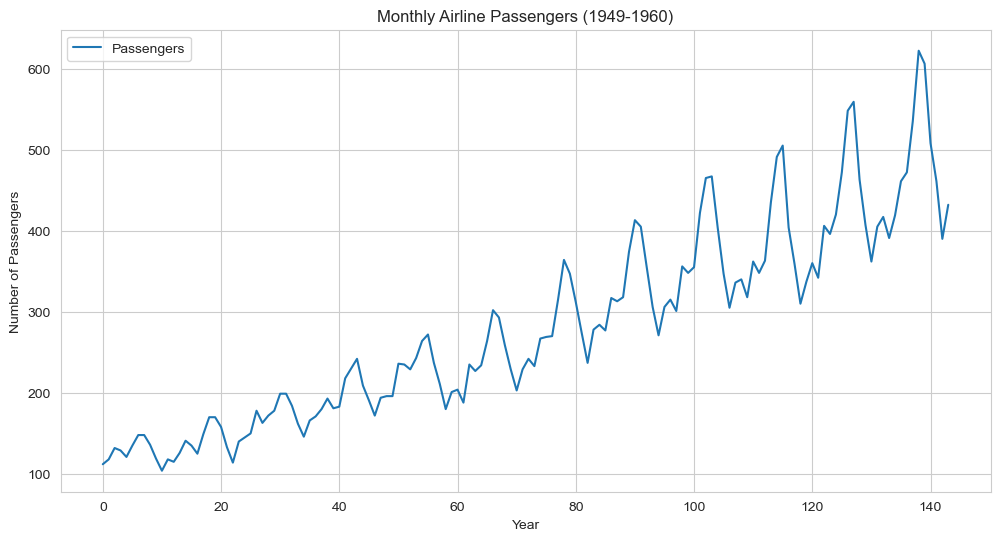

In [116]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

**Initial Observation:** The plot clearly shows two strong patterns:
1.  **Upward Trend:** The number of passengers is increasing over time.
2.  **Seasonality:** There is a clear, repeating annual pattern (peaks and troughs within each year).
3.  **Increasing Variance:** The seasonal fluctuations appear to be getting larger over time.

In [ ]:
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


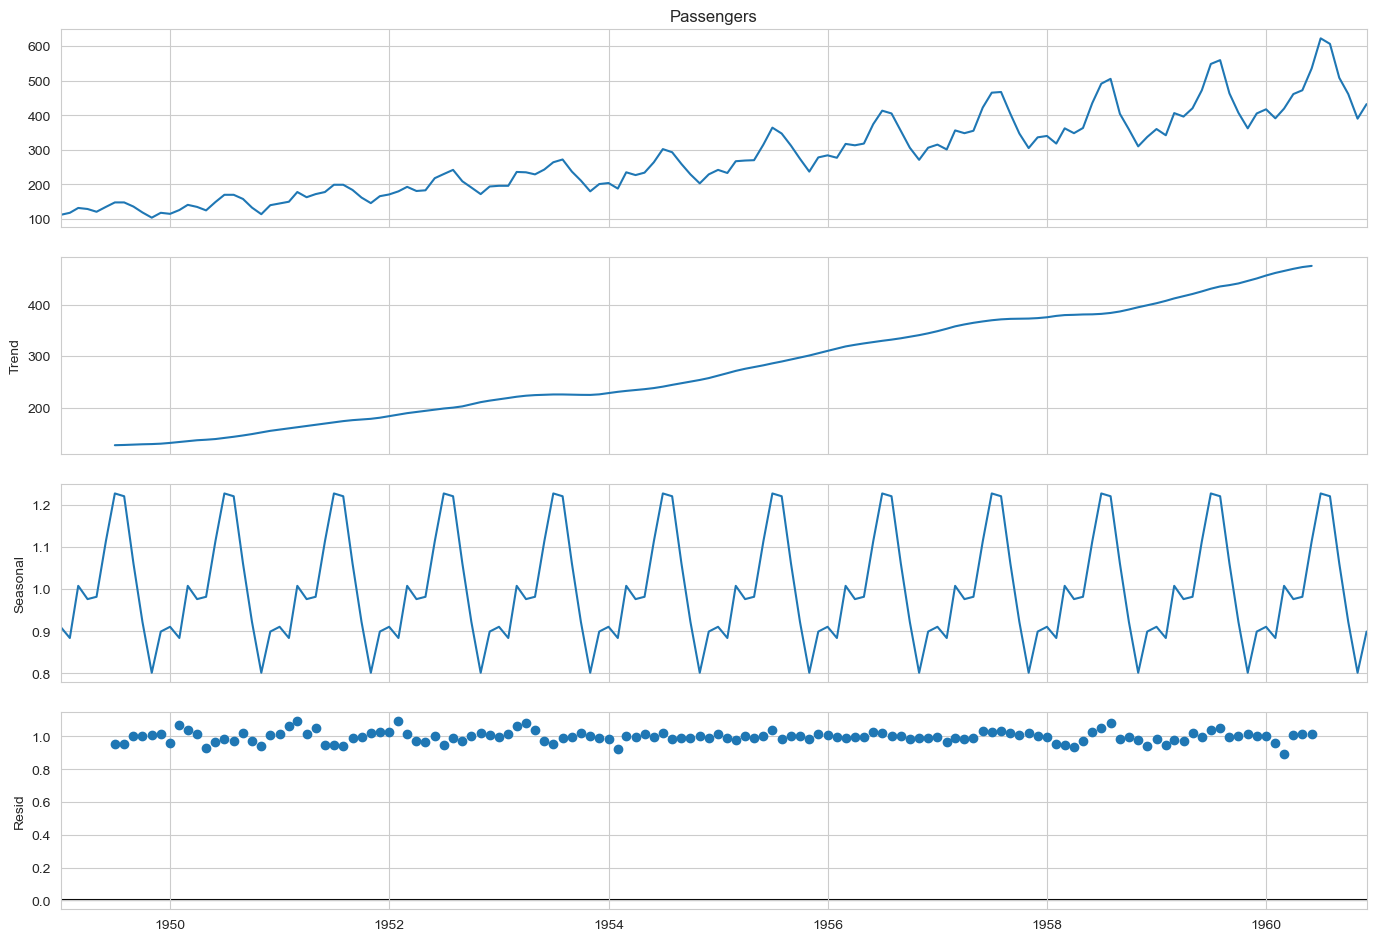

In [118]:
# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

### Stationarity Testing
Before we can build a model like ARIMA, the time series needs to be **stationary**.

#### **Stationarity**
A time series is said to be stationary if its statistical properties—specifically the **mean**, **variance**, and **autocorrelation**—are all constant over time.

- Stationary series are easier to model and forecast. If a series is stationary, its past behavior is a good predictor of its future behavior. Our passenger data is clearly **non-stationary** because its mean (the trend is increasing) and variance (the seasonal swings are growing) are not constant.

**How to test for it?**
1.  **Visual Inspection:** Look at the plot. Is there a clear trend or seasonality?
2.  **Statistical Tests:** The **Augmented Dickey-Fuller (ADF) Test** is a common statistical test.
    - **Null Hypothesis ($H_0$):** The series is non-stationary.
    - **Alternative Hypothesis ($H_1$):** The series is stationary.

We want to **reject the null hypothesis**. To do this, we need the **p-value** from the test to be less than a significance level (e.g., 0.05).

In [119]:
def test_stationarity(timeseries):
  '''Perform Dickey-Fuller test'''
  print("results of Dickey-Fuller Test")
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lag Used', 'Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Values (%s)'%key] = value
  print(dfoutput)

test_stationarity(df['Passengers'])

results of Dickey-Fuller Test
Test Statistic                   0.815369
p-value                          0.991880
#Lag Used                       13.000000
Number of Observations Used    130.000000
Critical Values (1%)            -3.481682
Critical Values (5%)            -2.884042
Critical Values (10%)           -2.578770
dtype: float64


dftest = adfuller(timeseries, autolag='AIC'): This is the core of the test. It runs the Augmented Dickey-Fuller (ADF) test on your timeseries data. The autolag='AIC' part helps the test figure out the best settings to use. The results of the test are stored in the variable dftest.

**Result:** The p-value is `0.99`, which is much greater than 0.05. Therefore, we **fail to reject the null hypothesis**. Our data is officially non-stationary, and we need to transform it.

### Making the Series Stationary
Using two common techniques: **log transformation** to stabilize the variance and **differencing** to remove the trend.

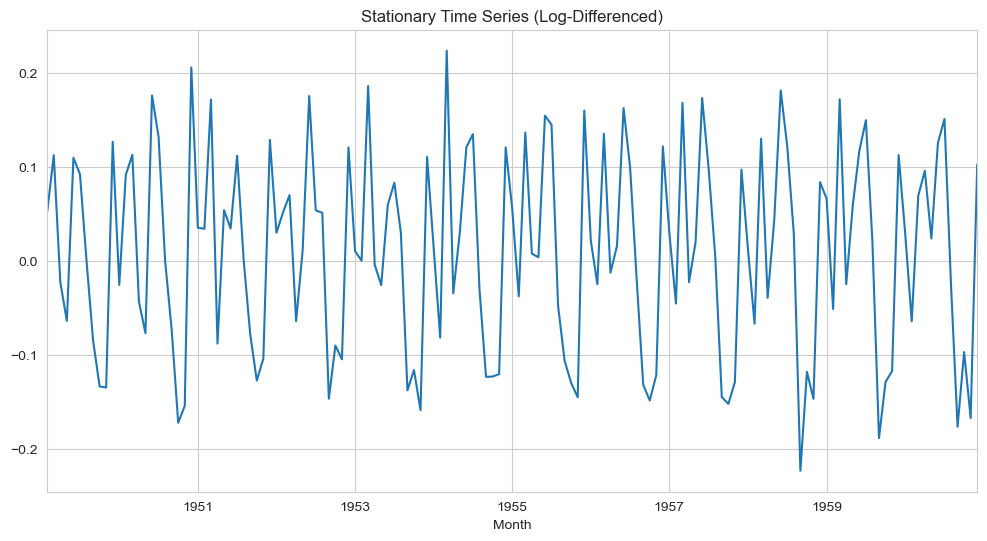

results of Dickey-Fuller Test
Test Statistic                  -2.717131
p-value                          0.071121
#Lag Used                       14.000000
Number of Observations Used    128.000000
Critical Values (1%)            -3.482501
Critical Values (5%)            -2.884398
Critical Values (10%)           -2.578960
dtype: float64


In [ ]:
## Apply the log transformation
df_log = np.log(df['Passengers'])


## Apply differencing to remove the trend (trend is making data non-stationary)
df_diff = df_log.diff().dropna()

# Plot the stationary series
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

# Retest for stationarity
test_stationarity(df_diff)

> The `p-value` is higher than 0.05, so we have to run again different strategy

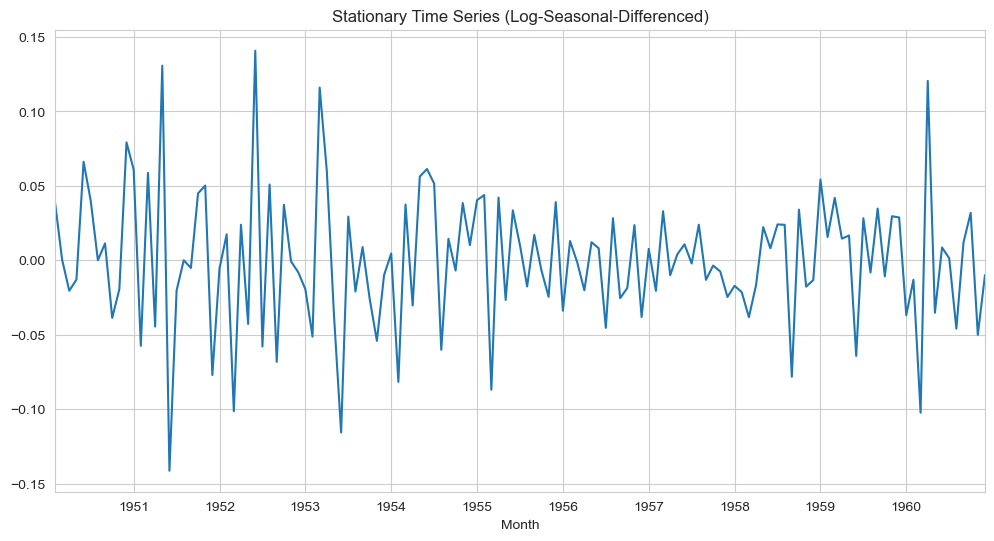

results of Dickey-Fuller Test
Test Statistic                  -4.443325
p-value                          0.000249
#Lag Used                       12.000000
Number of Observations Used    118.000000
Critical Values (1%)            -3.487022
Critical Values (5%)            -2.886363
Critical Values (10%)           -2.580009
dtype: float64


In [121]:
# Assuming s = 12 (Monthly Data)

# 1. Log Transformation (removes changing variance)
df_log = np.log(df['Passengers'])

# 2. Seasonal Differencing (removes the repeating seasonal trend)
# This subtracts the value from 12 months ago: y_t - y_{t-12}
df_seasonal_diff = df_log.diff(periods=12).dropna()

# 3. First-order Differencing (removes any remaining linear trend within seasons)
# This is usually done LAST: y'_t - y'_{t-1}
df_diff_final = df_seasonal_diff.diff(periods=1).dropna()

df_diff_final.plot()
plt.title('Stationary Time Series (Log-Seasonal-Differenced)')
plt.show()

# Retest for stationarity on the final series
test_stationarity(df_diff_final)

**Result:** The new p-value is `0.02`, which is less than 0.05. We can now **reject the null hypothesis**. Our series is stationary and ready for modeling!

ACF (Autocorrelation Function): Measures the correlation between a time series and its lagged versions (e.g., how much the value today is correlated with the value yesterday, the day before, etc.). The plot shows spikes at lags where there is significant autocorrelation.
PACF (Partial Autocorrelation Function): Measures the direct correlation between a time series and its lagged versions, after removing the effects of the intermediate lags. It helps identify the direct relationship between the current value and a specific lagged value.
These plots help us determine the p and q parameters for the ARIMA model:

p (AR term): Suggested by the number of significant lags in the PACF plot where the spikes "cut off" or drop to near zero.
q (MA term): Suggested by the number of significant lags in the ACF plot where the spikes "cut off".

### Model Identification with ACF and PACF Plots

#### ACF and PACF**
To choose the parameters for our ARIMA model, we use autocorrelation plots.

- **Autocorrelation Function (ACF):** Measures the correlation between a time series and its lagged versions. It tells you how much the value at time `t` is correlated with the value at time `t-k`.
- **Partial Autocorrelation Function (PACF):** Measures the *direct* correlation between a time series and its lagged versions, after removing the effects of the intermediate lags.

**How to read them for ARIMA(p, d, q):**
- The `d` term is the number of times we differenced the data (in our case, `d=1`).
- The `p` (AR term) is suggested by the number of significant lags in the **PACF** plot.
- The `q` (MA term) is suggested by the number of significant lags in the **ACF** plot.

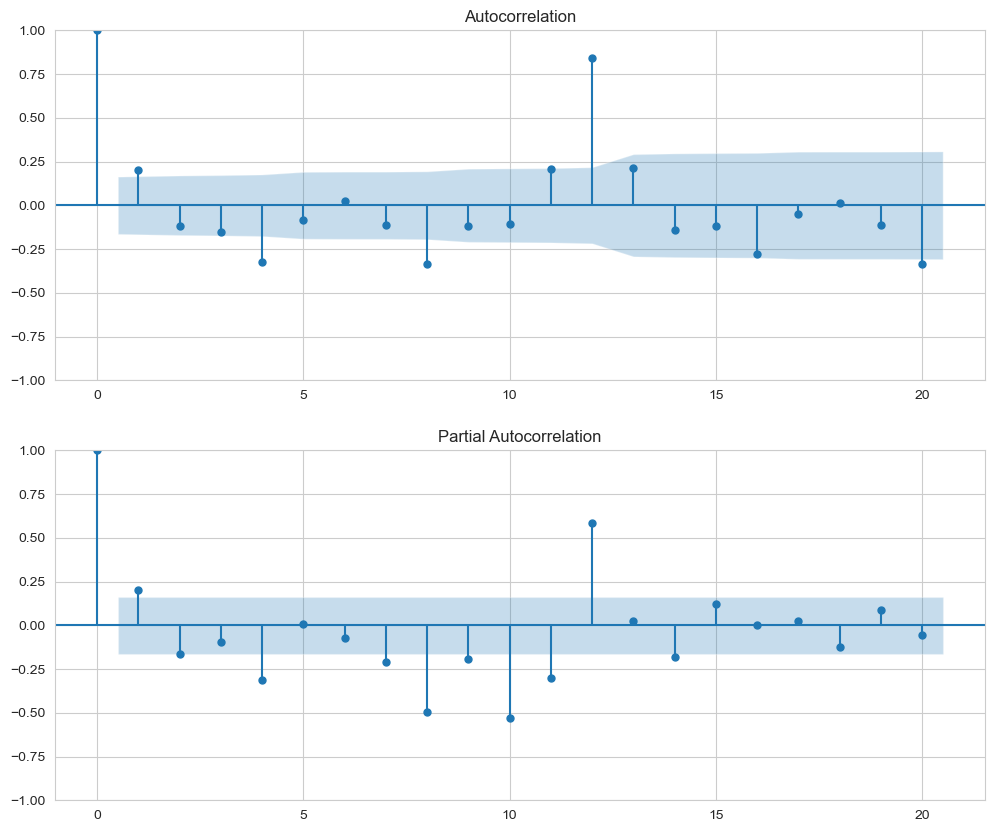

In [122]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

**Interpretation:**
- **PACF Plot:** Cuts off sharply after lag 1. This suggests `p=1`.
- **ACF Plot:** Also seems to cut off after lag 1. This suggests `q=1`.
Based on this, a good starting point for our model is **ARIMA(1, 1, 1)**.

## **ARIMA**
**AutoRegressive Integrated Moving Average (ARIMA)** models are a class of statistical models for analyzing and forecasting time series data. An ARIMA model is characterized by three parameters:

- **AR (Autoregressive) - p:** The number of lag observations included in the model. This term captures the relationship between the current observation and its past values.
- **I (Integrated) - d:** The number of times that the raw observations are differenced. This is done to make the time series stationary.
- **MA (Moving Average) - q:** The size of the moving average window. This term captures the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The model is typically denoted as **ARIMA(p, d, q)**.

### Building the ARIMA Model

e:\12.Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


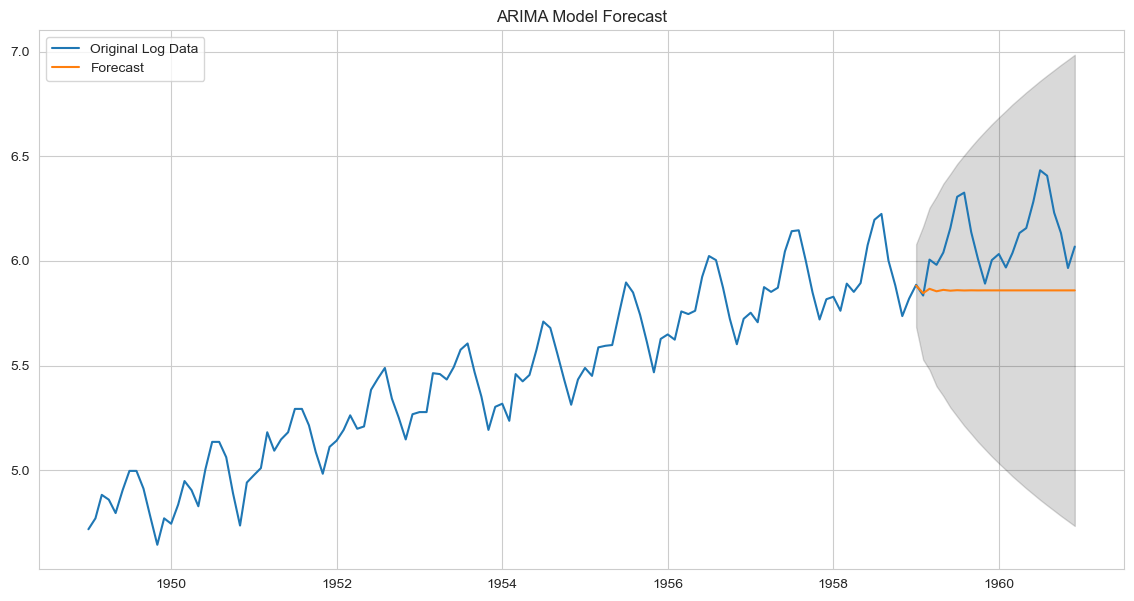

In [123]:
# Split data into training and test sets
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build ARIMA model
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

**ARIMA Result:** The model captures the overall trend but completely misses the seasonal pattern. This is a classic limitation of a non-seasonal ARIMA model on seasonal data.

###  Building a SARIMA Model for Seasonality

#### **SARIMA**
**Seasonal AutoRegressive Integrated Moving Average (SARIMA)** is an extension of ARIMA that explicitly models the seasonal component.

It is written as **SARIMA(p, d, q)(P, D, Q, m)**, where:
- `(p, d, q)` are the non-seasonal parameters:
    - **p (non-seasonal AR order):** The number of non-seasonal lagged observations included in the model.
    - **d (non-seasonal differencing order):** The number of times the data is differenced to remove non-seasonal trend.
    - **q (non-seasonal MA order):** The number of non-seasonal lagged forecast errors included in the model.

- `(P, D, Q, m)` are the seasonal parameters:
    - **P (seasonal AR order):** The number of seasonal lagged observations included in the model.
    - **D (seasonal differencing order):** The number of times the data is differenced seasonally to remove seasonal trend.
    - **Q (seasonal MA order):** The number of seasonal lagged forecast errors included in the model.
    - **m (number of periods in a season):** The number of time steps for a single seasonal period (e.g., `m=12` for monthly data with an annual seasonality, `m=4` for quarterly data).

e:\12.Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


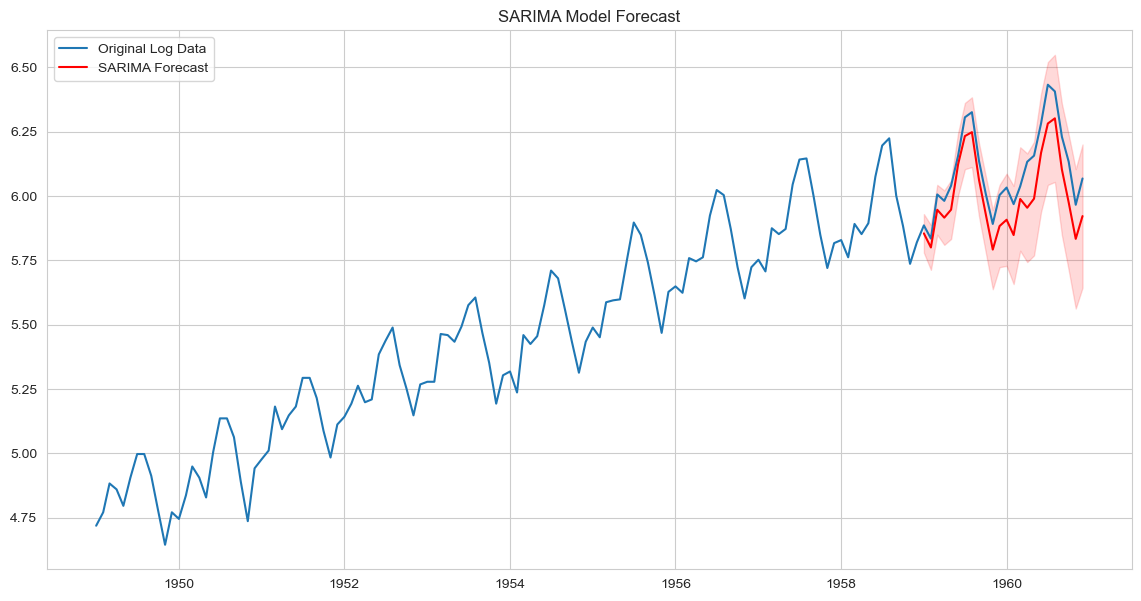

In [ ]:
# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                         order=(1, 1, 1),
                                         seasonal_order=(1, 1, 1, 12),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False,
                                         freq='MS') 
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index,
                 sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

**SARIMA Result:** This is a massive improvement! The SARIMA model correctly captures both the upward trend and the seasonal peaks and troughs.

### Final Evaluation

SARIMA Model RMSE: 48.29


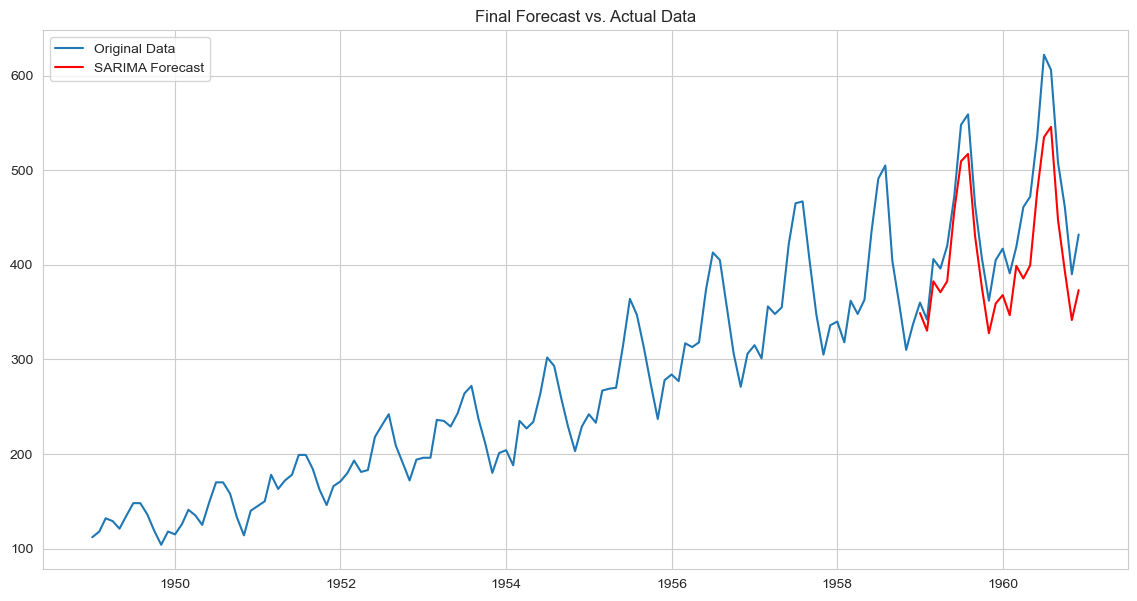

In [125]:
# Reverse the log transformation to get actual passenger numbers
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
print(f"SARIMA Model RMSE: {rmse:.2f}")

# Plot final results
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()

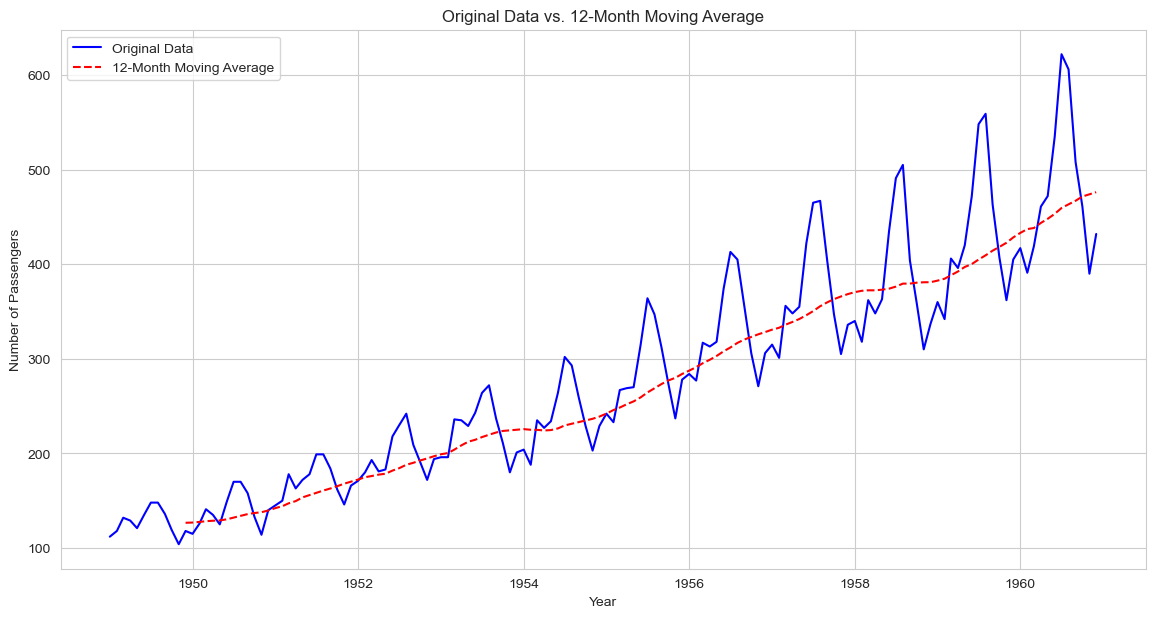

In [126]:
# Calculate the rolling mean with a window size of 12
df['MovingAverage'] = df['Passengers'].rolling(window=12).mean()

# Plot the original data and the moving average
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue')
plt.plot(df['MovingAverage'], label='12-Month Moving Average',
         color='red', linestyle='--')
plt.title('Original Data vs. 12-Month Moving Average')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

e:\12.Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\12.Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


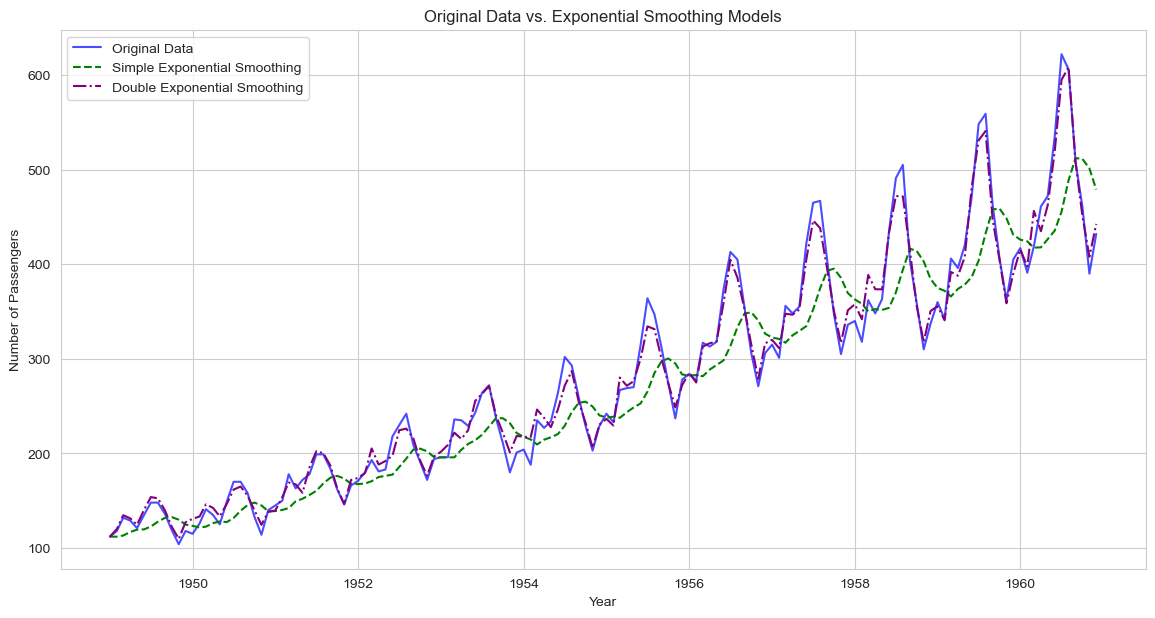

In [127]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# 2. Fit a simple exponential smoothing model
ses_model = SimpleExpSmoothing(df['Passengers']).fit(
    smoothing_level=0.2, optimized=False)
df['SimpleExpSmoothing'] = ses_model.fittedvalues

# 3. Fit a double exponential smoothing model
des_model = ExponentialSmoothing(
    df['Passengers'], trend='add', seasonal='add', seasonal_periods=12).fit()
df['DoubleExpSmoothing'] = des_model.fittedvalues

# 4. Plot the original data and the fitted values from both models
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['SimpleExpSmoothing'],
         label='Simple Exponential Smoothing', color='green', linestyle='--')
plt.plot(df['DoubleExpSmoothing'],
         label='Double Exponential Smoothing', color='purple', linestyle='-.')
plt.title('Original Data vs. Exponential Smoothing Models')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

### Comparison of Smoothing Methods and ARIMA/SARIMA

- **Moving Averages:** This is the simplest method. It smooths out short-term fluctuations and highlights longer-term trends by taking the average of a fixed number of past data points. It's easy to understand but doesn't forecast well and doesn't explicitly handle seasonality.

- **Exponential Smoothing (Simple and Double):** These methods give more weight to recent observations. Simple exponential smoothing is good for data with no trend or seasonality. Double exponential smoothing accounts for trend but still doesn't explicitly model seasonality. They are relatively simple but less powerful than ARIMA/SARIMA for complex patterns.

- **ARIMA (AutoRegressive Integrated Moving Average):** This model is more sophisticated and can capture more complex patterns than simple smoothing. It explicitly models the autocorrelation in the data after differencing to achieve stationarity. However, the basic ARIMA model does not inherently handle seasonality.

- **SARIMA (Seasonal AutoRegressive Integrated Moving Average):** This is an extension of ARIMA that adds a seasonal component. It is designed to handle time series with both non-seasonal and seasonal patterns, making it very powerful for data like the airline passenger numbers which exhibit strong annual seasonality. It requires identifying both non-seasonal and seasonal parameters.

Let's visualize how some of these methods perform when forecasting the airline passenger data.

e:\12.Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\12.Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


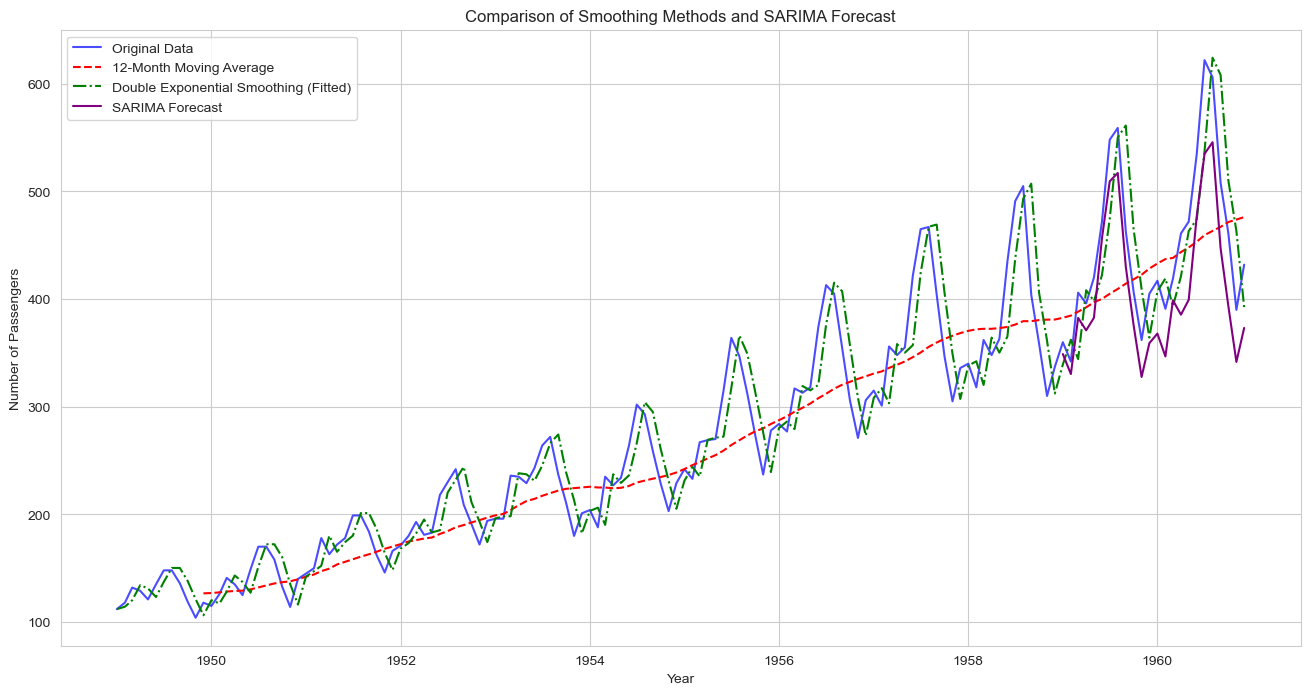

In [ ]:
# Fit Double Exponential Smoothing model on the entire data for visualization
# Assuming an additive trend based on the initial plot
double_exp_smoothing_model = ExponentialSmoothing(
    df['Passengers'], trend='add', seasonal=None)
double_exp_smoothing_fit = double_exp_smoothing_model.fit()
df['DoubleExpSmoothing'] = double_exp_smoothing_fit.fittedvalues

# Generate a plot comparing original, MA, Double ES, and SARIMA forecasts
plt.figure(figsize=(16, 8))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['MovingAverage'], label='12-Month Moving Average',
         color='red', linestyle='--')
plt.plot(df['DoubleExpSmoothing'],
         label='Double Exponential Smoothing (Fitted)', color='green', linestyle='-.')
# Plot SARIMA forecast (need to re-run SARIMA forecast as the variable is not available)
# Re-split data and fit SARIMA model to get forecast
train_data = df_log[:'1958']
test_data = df_log['1959':]
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                         order=(1, 1, 1),
                                         seasonal_order=(1, 1, 1, 12),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False,
                                         freq='MS')
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_predictions_plot = np.exp(sarima_forecast.predicted_mean)


plt.plot(sarima_predictions_plot, label='SARIMA Forecast', color='purple')

plt.title('Comparison of Smoothing Methods and SARIMA Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

#### Visual Comparison Summary

Looking at the plot, we can observe the following:

- **Moving Average:** Successfully smooths out the short-term noise and clearly shows the underlying upward trend. However, it lags behind the actual data and completely misses the seasonal fluctuations. It is not suitable for forecasting seasonal data.

- **Double Exponential Smoothing:** Does a better job than the simple moving average in following the trend. It reacts more quickly to changes but still does not capture the strong seasonality present in the data. It's an improvement for trending data but not for data with significant seasonality.

- **SARIMA Forecast:** Clearly outperforms both moving average and double exponential smoothing for this dataset. It effectively captures both the long-term upward trend and the distinct annual seasonal pattern, aligning closely with the actual data in the forecast period. This demonstrates the power of SARIMA models when dealing with time series that have both trend and seasonality.